In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [193]:
codebook = pd.read_csv('codebook.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [194]:
from sklearn.preprocessing import OrdinalEncoder

# Sample data with ordinal categorical variable
one_hot_columns = {
    'educa2': [f'educa2_{i}.0' for i in range(10,17)],
    'educ_ref': [f'educ_ref_{i}' for i in range(10,17)],
    'high_edu': [f'high_edu_{i}' for i in range(10, 17)],
    'building': [f'building_{i}' for i in range(2, 12)],
    'popsize': [f'popsize_{i}.0' for i in range(2, 6)],
    'childage': [f'childage_{i}' for i in range(1, 8)]
}

for column_key in one_hot_columns.keys():
  column_list = one_hot_columns[column_key]
  train[column_key] = train[column_list].idxmax(axis=1)
  train = train.drop(columns=column_list)
  encoder = OrdinalEncoder(categories=[column_list])
  train[column_key] = encoder.fit_transform(train[[column_key]])

  test[column_key] = test[column_list].idxmax(axis=1)
  test = test.drop(columns=column_list)
  encoder = OrdinalEncoder(categories=[column_list])
  test[column_key] = encoder.fit_transform(test[[column_key]])

In [195]:
# ONLY RUN IF LOG TRANSFORM

continuous_features = np.array(codebook[codebook['Type'] == 'continuous']['Variable Name'])
continuous_features = np.append(continuous_features, ['educa2', 'educ_ref', 'high_edu', 'building', 'popsize', 'childage'])
for feature in continuous_features:
  if not feature in ['age_ref', 'age2', 'medsuppq', 'dmsxccpq', 'medsrvpq', 'predrgpq']:
    train[feature] = np.log(train[feature]+1)
    test[feature] = np.log(test[feature]+1)

In [196]:
y = train['target'].values.reshape(-1, 1)
X = train.drop('target', axis=1)

X_train, X_test, y_train, y_validation = train_test_split(X, y, test_size=1/3, random_state=42)

In [188]:
# ONLY RUN IF UPSCALING

from sklearn.datasets import make_classification
from sklearn.utils import resample

# Convert to DataFrame for easier handling
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train.flatten())

# Check the class distribution before upsampling
print("Class distribution before upsampling:")
print(y_train_df.value_counts())

# Combine X_train and y_train for easier processing
train_data = pd.concat([X_train_df.reset_index(), y_train_df], axis=1)
train_data = train_data.drop(columns=['index'])

# Separate majority and minority classes
majority_class = train_data[train_data.iloc[:, -1] == 0]
minority_class = train_data[train_data.iloc[:, -1] == 1]

# Upsample the minority class
minority_class_upsampled = resample(minority_class,
                                     replace=True,     # Sample with replacement
                                     n_samples=len(majority_class),  # To match majority class
                                     random_state=42)  # Reproducible results

# Combine majority class with upsampled minority class
upsampled = pd.concat([majority_class, minority_class_upsampled])

# Shuffle the data
upsampled = upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the features and labels
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# Check the class distribution after upsampling
print("Class distribution after upsampling:")
print(y_train.value_counts())

y_train = np.array(y_train)
y_train = [[int(i)] for i in y_train]

Class distribution before upsampling:
0    10649
1     2772
Name: count, dtype: int64
Class distribution after upsampling:
0
1    10649
0    10649
Name: count, dtype: int64


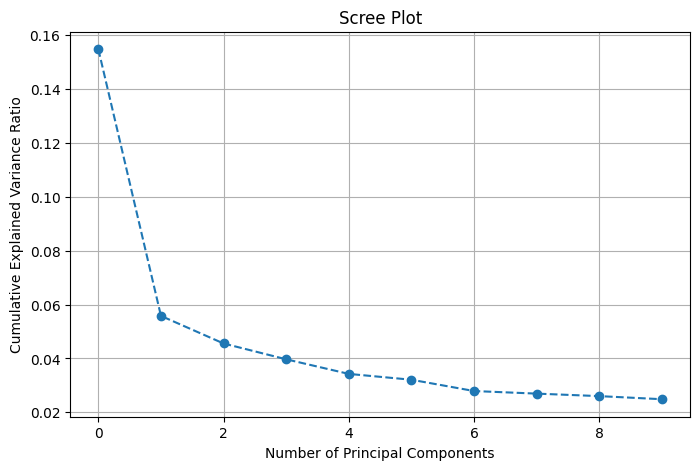

In [197]:
# STANDARDIZING AND SCALING

X_train_continuous = X_train[continuous_features]
X_train_processed = X_train.drop(columns=continuous_features)
X_test_continuous = X_test[continuous_features]
X_test_processed = X_test.drop(columns=continuous_features)

# Standardize the data (recommended before PCA)
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train_continuous)
X_test_continuous = scaler.transform(X_test_continuous)  # Do not fit again, only transform

# Apply PCA to the training data
n_components = 10
pca = PCA(n_components=n_components)  # Number of principal components
X_train_pca = pca.fit_transform(X_train_continuous)

# Transform the test data using the PCA model trained on the training data
X_test_pca = pca.transform(X_test_continuous)

X_train_combined = pd.concat([pd.DataFrame(X_train_pca, columns=[f'PCA_{i}' for i in range(n_components)]), X_train_processed.reset_index()], axis=1)
X_test_combined = pd.concat([pd.DataFrame(X_test_pca, columns=[f'PCA_{i}' for i in range(n_components)]), X_test_processed.reset_index()], axis=1)

X_train_combined = X_train_combined.drop(columns=['index'])
X_test_combined = X_test_combined.drop(columns=['index'])

explained_variance_ratio = pca.explained_variance_ratio_

# Create a scree plot
plt.figure(figsize=(8, 5))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [198]:
forest_clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)
forest_clf.fit(X_train_combined, y_train)
y_validation_pred = forest_clf.predict(X_test_combined)
acc = accuracy_score(y_validation, y_validation_pred)
print(acc)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8137386380569215


In [199]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=5,  # Maximum depth of a tree
    random_state=42  # Seed for reproducibility
)

# Train the model on the training set
xgb_model.fit(X_train_combined, y_train)

# Predict the test set
y_pred = xgb_model.predict(X_test_combined)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_validation, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7835


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the hyperparameters to optimize
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.6, 0.8, 1.0]
}

# # Setup the GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)

# # Fit GridSearchCV
# grid_search.fit(X_train_combined, y_train)

# # Best parameters and score
# print("Best Parameters: ", grid_search.best_params_)
# print("Best Cross-validation Score: ", grid_search.best_score_)


# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   scoring='accuracy', n_iter=100, cv=5, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_combined, y_train)

# Best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Cross-validation Score: ", random_search.best_score_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:11:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:11:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:11:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:11:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:11:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

KeyboardInterrupt: 